# Level 2: Rice Crop Yield Forecasting Tool Benchmark Notebook

## Challenge Level 2 Overview

<p align="justify">Welcome to the EY Open Science Data Challenge 2023! This challenge consists of two levels – Level 1 and Level 2. This is the Level 2 challenge aimed at participants who have intermediate or advanced skill sets in data science and programming. The goal of Level 2 is to predict the yield of rice crop at a given location using satellite data. By the time you complete this level, you would have developed a rice crop yield forecasting model, which can predict the yield of rice crop.
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict the yield of  rice crop in Vietnam using features from Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used statistical features generated from the bands (VV and VH) of the Sentinel-1 RTC dataset and mathematical combinations of these bands (VV/VH). We have trained an extra tree regressor model with these features. We have extracted the VV and VH band data from the Sentinel-1 dataset for summer autumn (SA) /winter spring (WS) season for the year 2022 based on the data provided.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    
<p align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

Please use <b>planetary_computer.settings.set_subscription_key</b> (<i style="color:#eb2f2f;">API Key</i>) and pass your API key here.

See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [954]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
# pc.settings.set_subscription_key('********************')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm.notebook import tqdm as tqdm
tqdm.pandas()

## Response Variable

Before building the model, we need to load in the rice crop yield data. In particular, rice crop yield data was collected for the period of late-2021 to mid-2022 over the Chau Phu, Chau Thanh and Thoai Son districts.

This is a dense rice crop region with a mix of double and triple cropping cycles.For this demonstration, we have assumed a triple cropping (3 cycles per year) for all the data points, but you are free to explore the impact of cropping cycles on the yield.You will have to map every data point with its corresponding crop cycle.
The crop cycles are Winter-Spring ( November – April) and the Summer-Autumn (April – August). E.g., the harvest date for the first entry is 15th July 2022. The corresponding crop cycle will be Summer-Autumn (April – August). 

The data consists of geo locations (Latitude and Longitude), District, Season, Rice Crop Intensity, Date of Harvest, Field Size (in Hectares) with the yield in each geo location.

In [604]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv", parse_dates=['Date of Harvest'])
crop_yield_data.columns = ['district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
crop_yield_data.head()

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,2022-07-15,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,2022-07-15,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,2022-07-14,3.30,6400


In [605]:
crop_yield_data[crop_yield_data.duplicated(subset=['latitude', 'longitude'], keep=False)].sort_values(['latitude', 'longitude'])

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
449,Thoai_Son,10.195117,105.200047,SA,T,2022-07-20,3.20,5600
531,Thoai_Son,10.195117,105.200047,WS,T,2022-05-04,3.20,7200
445,Thoai_Son,10.208515,105.202809,SA,T,2022-07-20,2.67,6400
527,Thoai_Son,10.208515,105.202809,WS,T,2022-05-04,2.67,7200
451,Thoai_Son,10.227394,105.164987,SA,T,2022-07-20,3.00,5600
...,...,...,...,...,...,...,...,...
119,Chau_Phu,10.636733,105.155635,WS,T,2022-10-04,3.20,8000
28,Chau_Phu,10.649258,105.142121,SA,D,2022-05-08,1.75,6000
120,Chau_Phu,10.649258,105.142121,WS,D,2022-10-04,1.75,8000
29,Chau_Phu,10.663484,105.168203,SA,D,2022-05-08,3.00,6500


In [606]:
sub_sample = pd.read_csv("Challenge_2_submission_template.csv", parse_dates=['Date of Harvest'])
sub_sample.columns = ['id', 'district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
sub_sample.head()

,id,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,1,Chau_Phu,10.542192,105.187920,WS,T,2022-10-04,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,2022-10-04,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN


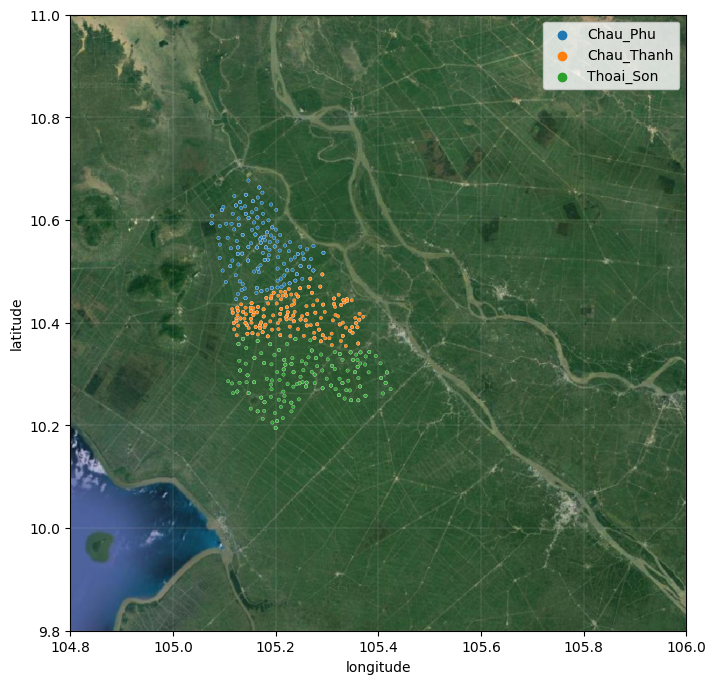

In [607]:
sns.scatterplot(data=crop_yield_data, x='longitude', y='latitude', hue='district', s=6)

fig = plt.gcf()
ax  = plt.gca()

fig.set_size_inches(8, 8)

ax.set_aspect('equal')
ax.patch.set_alpha(0)
plt.grid(lw=0.15)
plt.legend()
# legend.legendHandles[0]._sizes = [40]
# legend.legendHandles[1]._sizes = [40]
# legend.set_alpha(0)

plt.xlim(104.8, 106)
plt.ylim(9.8, 11)

# [0.06, 0, 0.95, 0.95]

newax = fig.add_axes(ax.get_position(), anchor='SW', zorder=-15)
# newax.set_position(ax.get_position())
newax.imshow(plt.imread('../Full Region no labels.jpg'), aspect='auto')
newax.axis('off')
plt.grid(False)

## Predictor Variables

<p align ="justify">Now that we have our crop yield data, it is time to gather and generate the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.

   

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Here we are generating timeseries band values over a period of four months.</p>

<p align = "justify">
A time series data is made up of data points that are collected at regular intervals and are dependent on one another. Many of the tasks involved in data modelling depend heavily on feature engineering. This is only a technique that identifies key aspects of the data that a model might use to improve performance. Because time series modelling uses sequential data that is produced by changes in any value over time, feature engineering operates differently in this context. Creation of statistical features using time series data is one of the feature engineering techniques. Here, we create statistical features using the band values (VV and VH) and the mathematical combination of band values (VV/VH) from Sentinel-1 dataset that aid in predicting the rice yield.
</p>
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
       
</ul>

    
<p align = "justify"><b> Note : Any model utilizing “season” as predictor will be ruled invalid. Examples of seasons include Winter Spring, Summer Autumn etc. But you can use season information to extract the satellite data.</b></p> 

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants can consider the use of optical data from Sentinel-2 and Landsat. All of these datasets are readily available from the <a href="https://planetarycomputer.microsoft.com/"> Microsoft Planetary Computer</a>. Participants can choose one or more of these satellite datasets for their solution. Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation, whereas the data from the Sentinel-2 and Landsat data may contain attenuation due to the presence of cloud.</p>

<p align="justify"> Participants should also note that Sentinel-1 provides a consistent 12 day revist whereas the optical data may be missing due to extreme cloud cover for an entire scene or particular pixels having cloud contanimation. Please refer the sample notebooks provided for <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb">Sentinel-1</a>, <a href="https://challenge.ey.com/api/v1/storage/admin-files/200864767105553-63ca8c57aea56e00146e319c-Sentinel%202%20cloud%20filtering.ipynb">Sentinel-2</a> and <a href="https://challenge.ey.com/api/v1/storage/admin-files/36808312288709755-63ca8ccb7b1fe300146c7917-Landsat%20cloud%20filtering.ipynb">Landsat</a> to get more details about filtering and using these datasets.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data or from other satellites. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3</strong></h4>
<p align ="justify"> Participants are suggested to choose the time of interest based on the phenology curves and comprehend the patterns of the rice cycle rather than just choosing the first and last day of the season.</p>

# Process Data

## Constant Features

In [608]:
crop_yield_data.head(2)

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000


In [610]:
train_const_data = pd.get_dummies(crop_yield_data.drop(['season', 'district'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
sub_const_data   = pd.get_dummies(sub_sample.drop(['season', 'district', 'rice_yield', 'id'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,intensity_T
0,2022-07-15,3.40,5500,1
1,2022-07-15,2.43,6000,1


,date_of_harvest,field_size,intensity_T
0,2022-10-04,1.40,1
1,2022-07-15,1.32,1


In [611]:
train_const_data['start_of_harvest']     = train_const_data.date_of_harvest - pd.to_timedelta('100d')
sub_const_data  ['start_of_harvest']     = sub_const_data.date_of_harvest -   pd.to_timedelta('100d')
train_const_data['dayofyear_of_harvest'] = train_const_data.date_of_harvest.dt.day_of_year
sub_const_data['dayofyear_of_harvest']   = sub_const_data.date_of_harvest.dt.day_of_year
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-07-15,3.40,5500,1,2022-04-06,196
1,2022-07-15,2.43,6000,1,2022-04-06,196


,date_of_harvest,field_size,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-10-04,1.40,1,2022-06-26,277
1,2022-07-15,1.32,1,2022-04-06,196


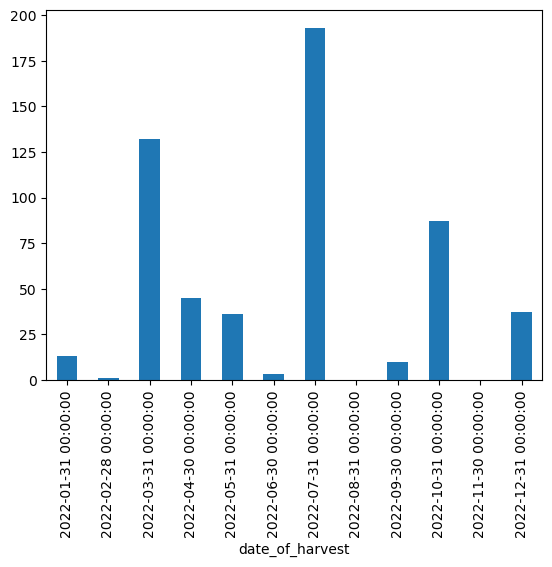

<AxesSubplot: xlabel='date_of_harvest'>

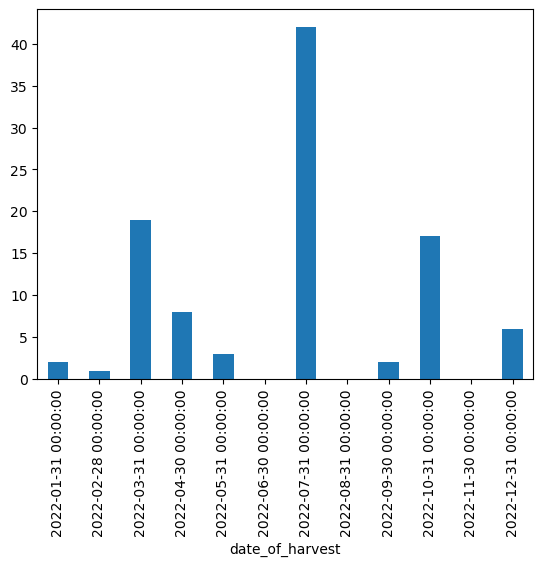

In [612]:
train_const_data.set_index('date_of_harvest').resample('m').count().iloc[:, 0].plot.bar()
plt.show()
sub_const_data.set_index('date_of_harvest').resample('m').count().iloc[:, 0].plot.bar()

Text(0.5, 1.0, 'Yield by date and by intensity')

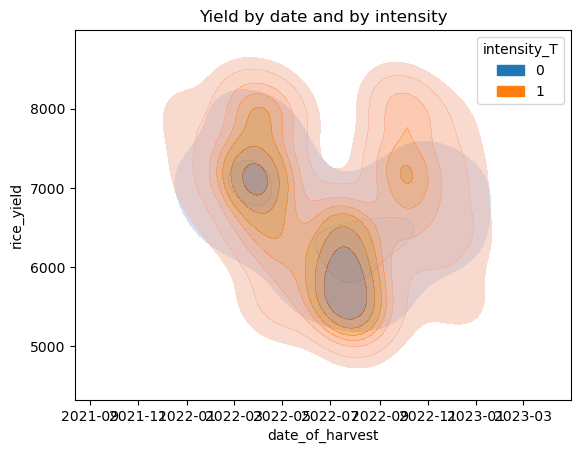

In [613]:
sns.kdeplot(data=train_const_data, x='date_of_harvest', y='rice_yield', hue='intensity_T', levels=8, fill=True, alpha=0.5)
plt.title('Yield by date and by intensity')

<AxesSubplot: >

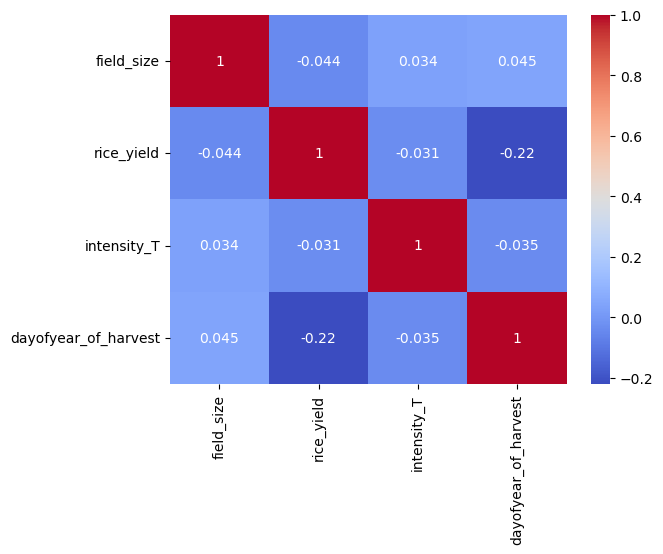

In [614]:
sns.heatmap(train_const_data.corr(), cmap='coolwarm', annot=True)

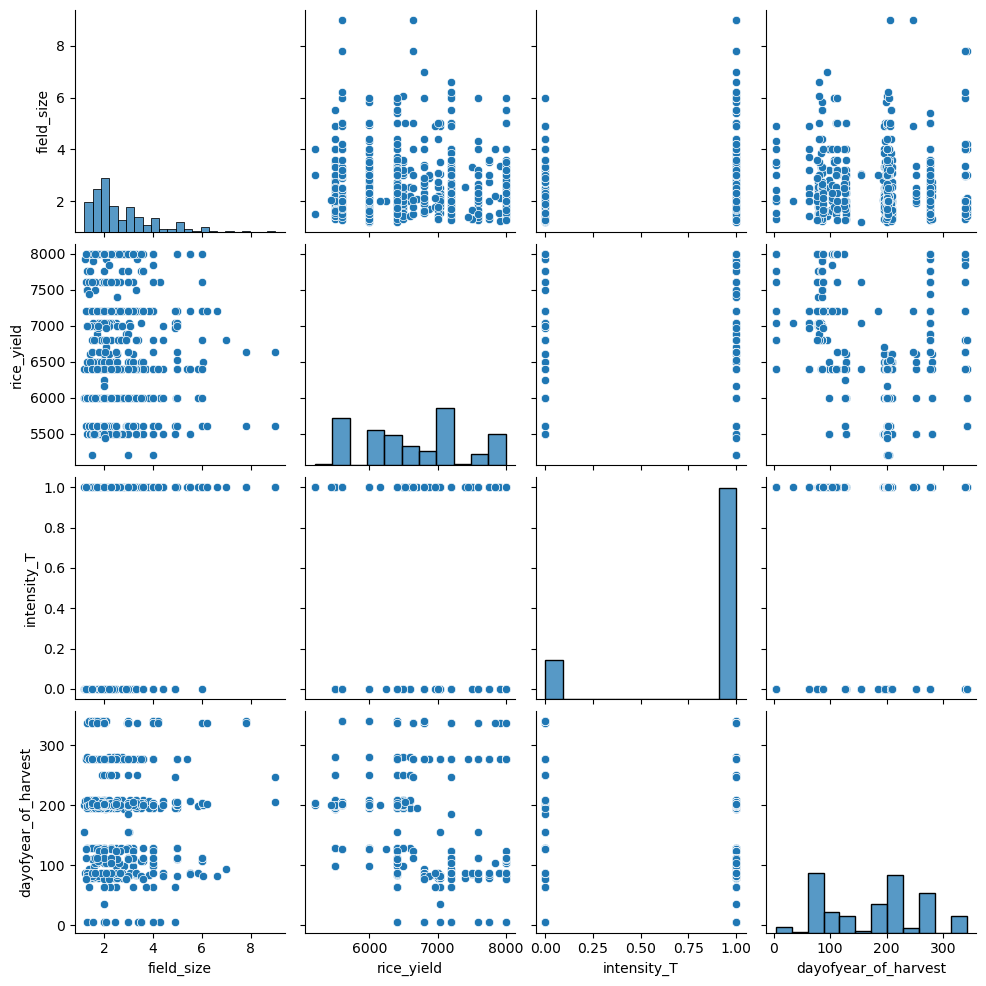

In [615]:
sns.pairplot(train_const_data)

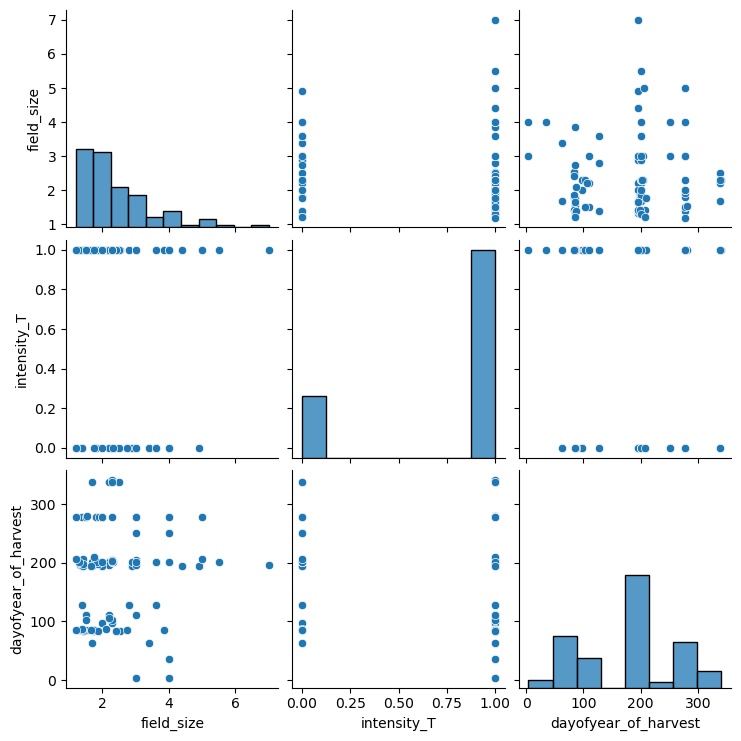

In [616]:
sns.pairplot(sub_const_data)

## Time Series features

In [617]:
train_ts_data = pd.read_csv('train_data_level2.csv', index_col=['index', 'datetime'], parse_dates=True)
sub_ts_data   = pd.read_csv('sub_data_level2.csv'  , index_col=['index', 'datetime'], parse_dates=True)
display(train_ts_data.head(2), sub_ts_data.head(2))

vh        vv       rvi
index datetime                                                
0     2021-09-05 22:45:35.619475  0.006411  0.036697  0.229400
      2021-09-11 22:46:08.311308  0.019033  0.295205  0.059627

vh        vv       rvi
index datetime                                                
0     2021-09-05 22:45:35.619475  0.009871  0.085611  0.132962
      2021-09-11 22:46:08.311308  0.007774  0.089595  0.090244

In [618]:
# Drop a column
# train_ts_data = train_ts_data.drop(['vh'], axis=1)
# sub_ts_data = sub_ts_data.drop(['vh'], axis=1)
# display(train_ts_data.head(2), sub_ts_data.head(2))

In [619]:
# Add ratio vv/vh
# train_ts_data = train_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# sub_ts_data = sub_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# display(train_ts_data.head(2), sub_ts_data.head(2))

In [620]:
def is_outlier(series, factor=1, print_range=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR*factor
    upper_bound = Q3 + 1.5 * IQR*factor
    if print_range:
        print(upper_bound, lower_bound)
    boolean_filter = (series < lower_bound) | (series > upper_bound)
    return pd.Series(np.where(boolean_filter,
                                       np.nan,
                                       series),
                              index=series.index)

<AxesSubplot: >

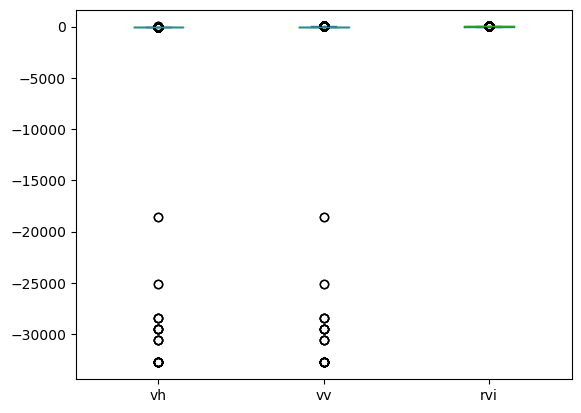

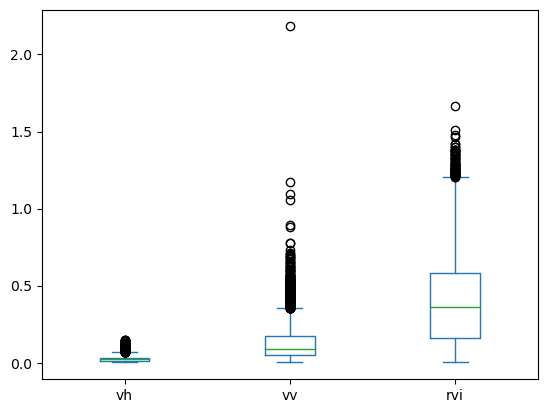

In [621]:
# Check boxplot with different outliers filters
train_ts_data.plot.box()
sub_ts_data.plot.box()

In [622]:
train_ts_data = train_ts_data.apply(is_outlier, args=[1])
sub_ts_data   = sub_ts_data.apply(  is_outlier, args=[1])

<AxesSubplot: >

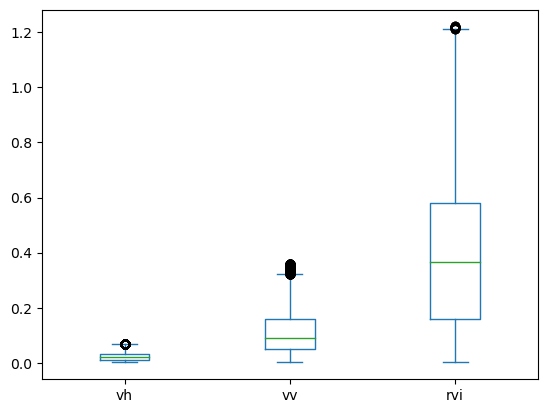

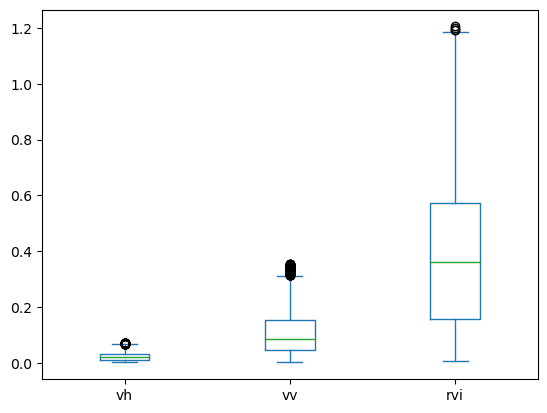

In [623]:
# Check boxplot after outlier filters
train_ts_data.plot.box()
sub_ts_data.plot.box()

In [624]:
# interpolate all datetimes
# for that we unstack the index, do the interpolation, then restack
train_ts_data = train_ts_data.unstack(level=0).resample('1d').mean().interpolate().bfill().rolling(15).mean().bfill().stack().swaplevel().sort_index(level=0)
sub_ts_data   = sub_ts_data.unstack(  level=0).resample('1d').mean().interpolate().bfill().rolling(15).mean().bfill().stack().swaplevel().sort_index(level=0)
display(train_ts_data.head(2), sub_ts_data.head(2))

vh        vv       rvi
index datetime                                
0     2021-09-05  0.020373  0.220996  0.135964
      2021-09-06  0.020373  0.220996  0.135964

vh        vv       rvi
index datetime                                
0     2021-09-05  0.007766  0.141064  0.146023
      2021-09-06  0.007766  0.141064  0.146023

## Slicing time frame

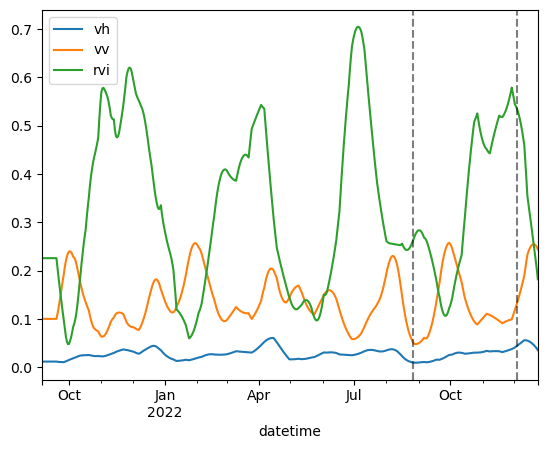

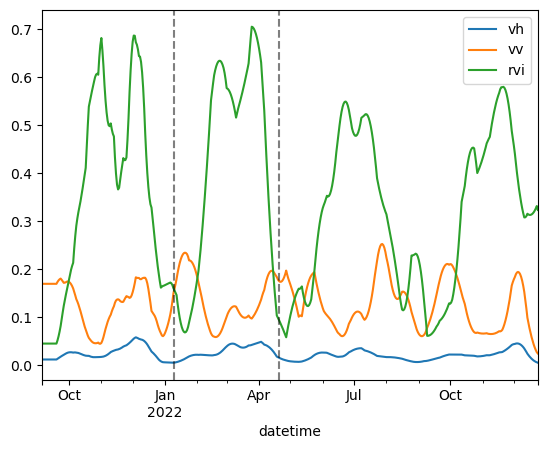

In [625]:
# Visualize data for one random sample
rand = np.random.randint(0, 550)
train_ts_data.loc[rand].plot()
[plt.axvline(train_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];

# Visualize data for one random sample
rand = np.random.randint(0, 99)
sub_ts_data.loc[rand].plot()
[plt.axvline(sub_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];

In [626]:
# Create slices to keep only 100 days prior to harvest for each coordinate
harvest_slices = []
for idx in range(len(train_const_data)):
    harvest_slices.append((idx, slice(train_const_data.loc[idx, 'start_of_harvest'], train_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(train_ts_data.loc[hs, :])
    
# Keep data that is 120 days from harvest
train_ts_data = pd.concat(data_slices)

# Sub
harvest_slices = []
for idx in range(len(sub_const_data)):
    harvest_slices.append((idx, slice(sub_const_data.loc[idx, 'start_of_harvest'], sub_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(sub_ts_data.loc[hs, :])
    
# Keep data that is 120 days from harvest
sub_ts_data = pd.concat(data_slices)

In [627]:
# Check that all time_series are the same length
display(train_ts_data.groupby(level=0).count().iloc[:, 0].describe(), sub_ts_data.groupby(level=0).count().iloc[:, 0].describe())

count    557.0
mean     101.0
std        0.0
min      101.0
25%      101.0
50%      101.0
75%      101.0
max      101.0
Name: vh, dtype: float64

count    100.0
mean     101.0
std        0.0
min      101.0
25%      101.0
50%      101.0
75%      101.0
max      101.0
Name: vh, dtype: float64

## Extra constant features (time series descriptors)

<p align="justify">
Auto Correlation - Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. Autocorrelation measures the relationship between a variable's current value and its past values.
</p>

<p align="justify">
Permutation Entropy - Permutation Entropy (PE) is a robust time series tool which provides a quantification measure of the complexity of a dynamic system by capturing the order relations between values of a time series and extracting a probability distribution of the ordinal patterns.
</p>
<p>You are encouraged to identify possible time series metrices that can be used as features.</p>

Tip 5  
Participants can generate other statistical features which are statiscally significant to understand characterstics of rice phenology. There are existing packages available which can generate some of these metrics for you.

In [628]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [629]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [630]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        print(row)
        print(row['vv'])
        print(min(row))
        min_vv = min(row['vv'])
        max_vv = max(row['vv'])
        range_vv = max_vv - min_vv
        mean_vv = np.mean(row['vv'])
        correlation_vv = sm.tsa.acf(row['vv'])[1]
        permutation_entropy_vv = permutation_entropy(row[0], dx=6,base=2, normalized=True) 
    
        min_vh = min(row['vh'])
        max_vh = max(row['vh'])
        range_vh = max_vh - min_vh
        mean_vh = np.mean(row['vh'])
        correlation_vh = sm.tsa.acf(row['vh'])[1]
        permutation_entropy_vh = permutation_entropy(row[1], dx=6, base=2, normalized=True)
    
        min_vv_by_vh = min(row['rvi'])
        max_vv_by_vh = max(row['rvi'])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean(row['rvi'])
        correlation_vv_by_vh = sm.tsa.acf(row['rvi'])[1]
        permutation_entropy_vv_by_vh = permutation_entropy(row[2], dx=6, base=2, normalized=True)
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, correlation_vv, permutation_entropy_vv,
                          min_vh, max_vh, range_vh,  mean_vh, correlation_vh, permutation_entropy_vh,
                          min_vv_by_vh,  max_vv_by_vh, range_vv_by_vh, mean_vv_by_vh, correlation_vv_by_vh, permutation_entropy_vv_by_vh])
    return features_list

In [1071]:
def generate_stastical_features_fix(group):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    out = group.agg(['min', 'max', 'ptp', 'mean'])

    for i in range(20):
        out.loc[f'auto_corr_{i+1}', :] = group.apply(lambda x:sm.tsa.acf(x)[i+1])

    out.loc['permut_entropy', :] = group.apply(lambda x:permutation_entropy(x, dx=6, base=2, normalized=True))
        
    return out

In [1072]:
descriptors_train = train_ts_data.groupby(level=0).progress_apply(lambda x:generate_stastical_features_fix(x))
descriptors_sub   = sub_ts_data.groupby  (level=0).progress_apply(lambda x:generate_stastical_features_fix(x))

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [1073]:
descriptors_train = descriptors_train.unstack().droplevel(0, axis=1)
descriptors_sub   = descriptors_sub.unstack().droplevel(0, axis=1)
display(descriptors_train.head(2), descriptors_sub.head(2))

,min,max,ptp,mean,auto_corr_1,auto_corr_2,auto_corr_3,auto_corr_4,auto_corr_5,auto_corr_6,...,auto_corr_12,auto_corr_13,auto_corr_14,auto_corr_15,auto_corr_16,auto_corr_17,auto_corr_18,auto_corr_19,auto_corr_20,permut_entropy
index,,,,,,,,,,,,,,,,,,,,,
0,0.006210,0.034837,0.028626,0.023595,0.991305,0.970709,0.938898,0.896651,0.844683,0.783853,...,0.624178,0.571860,0.518141,0.463502,0.408427,0.353222,0.298524,0.24461,0.191740,0.205841
1,0.027267,0.055780,0.028514,0.042119,0.992467,0.977278,0.954905,0.925842,0.890599,0.850385,...,0.313221,0.299947,0.284575,0.267972,0.251155,0.234655,0.218884,0.20470,0.193141,0.432478


,min,max,ptp,mean,auto_corr_1,auto_corr_2,auto_corr_3,auto_corr_4,auto_corr_5,auto_corr_6,...,auto_corr_12,auto_corr_13,auto_corr_14,auto_corr_15,auto_corr_16,auto_corr_17,auto_corr_18,auto_corr_19,auto_corr_20,permut_entropy
index,,,,,,,,,,,,,,,,,,,,,
0,0.005022,0.037953,0.032931,0.021281,0.988783,0.973786,0.955323,0.933654,0.909076,0.881909,...,0.462568,0.414425,0.369291,0.325738,0.284110,0.244623,0.207604,0.172816,0.140022,0.333593
1,0.009806,0.031621,0.021815,0.022670,0.981650,0.950960,0.909063,0.857158,0.796084,0.726593,...,0.596998,0.550526,0.504278,0.458775,0.414589,0.371557,0.329516,0.288425,0.248259,0.342366


In [1075]:
train_const_data = pd.concat([train_const_data, descriptors_train], axis=1)
sub_const_data   = pd.concat([sub_const_data  , descriptors_sub], axis=1)
train_const_data.head(2)

,date_of_harvest,field_size,rice_yield,intensity_T,start_of_harvest,dayofyear_of_harvest,min,max,ptp,mean,...,auto_corr_12,auto_corr_13,auto_corr_14,auto_corr_15,auto_corr_16,auto_corr_17,auto_corr_18,auto_corr_19,auto_corr_20,permut_entropy
0,2022-07-15,3.40,5500,1,2022-04-06,196,0.006210,0.034837,0.028626,0.023595,...,0.624178,0.571860,0.518141,0.463502,0.408427,0.353222,0.298524,0.24461,0.191740,0.205841
1,2022-07-15,2.43,6000,1,2022-04-06,196,0.027267,0.055780,0.028514,0.042119,...,0.313221,0.299947,0.284575,0.267972,0.251155,0.234655,0.218884,0.20470,0.193141,0.432478


<AxesSubplot: >

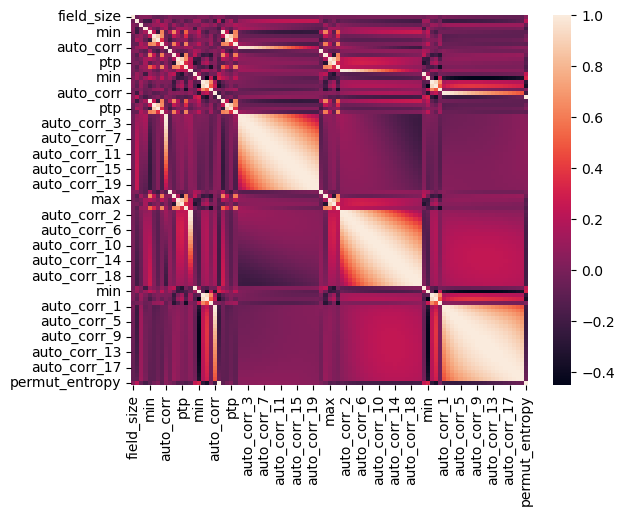

In [1076]:
sns.heatmap(train_const_data.corr())

# Create Model

In [1151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

def TrainTorch(xtrain, xtrain_const, ytrain, val_data, xval_const):
    # class Net(nn.Module):
    #     def __init__(self, input_size, n_classes):
    #         super().__init__()
    #         self.fc1 = nn.Linear(input_size, 1024)
    #         self.fc2 = nn.Linear(1024, 512)
    #         self.fc3 = nn.Linear(512, n_classes)

    #     def forward(self, x):
    #         x = F.relu(self.fc1(x))
    #         x = F.relu(self.fc2(x))
    #         x = self.fc3(x)
    #         return x

    dataset = TensorDataset(xtrain, ytrain)
    dataset_constant = TensorDataset(xtrain_const)
    
    if val_data==(None, None):
        dataset_train, dataset_val = torch.utils.data.random_split(dataset, [0.8, 0.2])
    else:
        dataset_train = dataset
        dataset_val   = TensorDataset(*list(val_data))
        dataset_val_constant   = TensorDataset(xval_const)
        print('Setting custom data as val data')

    class HybridModel(nn.Module):
        def __init__(self, n_features, time_series_length):
            super(HybridModel, self).__init__()

            self.conv1 = nn.Conv1d(n_features, 8, kernel_size=51, stride=1, padding='same')
            self.relu = nn.ReLU()
            self.batchnorm = nn.BatchNorm1d(8)
            self.pool = nn.MaxPool1d(2)
            self.fc1 = nn.Linear(time_series_length//2*8 + xtrain_const.shape[1], 64)
            self.drop = nn.Dropout(0.2)
            self.fc2 = nn.Linear(64, 64)
            self.out = nn.Linear(64, 1)

        def forward(self, x, x2):
            x = self.conv1(x)
            x = self.relu(x)
            x = self.batchnorm(x)
            x = self.pool(x)
            
            x = x.flatten(start_dim=1)
            
            # Concatenate the constant features with the output from the convolutional part
            x = torch.cat((x, x2), dim=1)
            
            x = F.relu(self.fc1(x))
            x = self.drop(x)
            x = self.fc2(x)
            x = self.out(x)

            return x
        
    model = HybridModel(n_features, time_series_length)
        
    model_ = nn.Sequential(nn.Conv1d(n_features, 8, kernel_size=51, stride=1, padding='same'),
                          nn.ReLU(),
                          
                          nn.BatchNorm1d(8),
                          nn.MaxPool1d(2),
                          
#                           nn.Conv1d(8, 8, kernel_size=8, stride=4),
#                           nn.ReLU(),
                          
#                           nn.BatchNorm1d(8),
#                           nn.MaxPool1d(2),
                          
                          # nn.Conv1d(64, 128, kernel_size=3, padding='same'),
                          # nn.ReLU(),
                          
                          # nn.Conv1d(128, 256, kernel_size=3, padding='same'),
                          # nn.ReLU(),
                          
                          # nn.BatchNorm1d(128),
                          # nn.MaxPool1d(2),
                          
                          nn.Flatten(),
                          
                          nn.Linear(time_series_length//2*8, 4),
                          # nn.Linear(72, 1),
                          
                          nn.Linear(4, 1)
                         )

    lr = 10**(-4)
    wd = 10**-2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss()
    batch_size = 4
    n_batches_train = (len(dataset_train) - 1)//batch_size+1
    n_batches_val   = (len(dataset_val  ) - 1)//batch_size+1
    epochs = 500

    dataloader_train = DataLoader(dataset_train    , batch_size=batch_size, shuffle=False)
    dataloader_train_constant = DataLoader(dataset_constant    , batch_size=batch_size, shuffle=False)
    dataloader_val   = DataLoader(dataset_val      , batch_size=batch_size, shuffle=False)
    dataloader_val_constant   = DataLoader(dataset_val_constant      , batch_size=batch_size, shuffle=False)

    stopping_counter = 0
    min_val_loss = np.inf
    best_r2 = -np.inf
    for epoch_n, epoch in tqdm(enumerate(range(epochs)), total=epochs):

        train_loss = 0.0
        model.train()
        for i, ((x_, y_), x2) in enumerate(zip(dataloader_train, dataloader_train_constant)):
            
            x2 = x2[0]
            
            preds = model(x_, x2)
            
            # Compute the loss and printing ever 10 iterations
            loss = criterion(preds, y_)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # if (i+1)%(n_batches_train//5) == 0:
            #     print(i, '\t', np.round(train_loss/i, 4))

        val_loss = 0.0
        model.eval()
        for ((x__, y__), x2) in zip(dataloader_val, dataloader_val_constant):

            x2 = x2[0]
            
            # Forward Pass
            preds = model(x__, x2)

            # Find the Loss
            loss = criterion(preds, y__)

            # Calculate Loss
            val_loss += loss.item()
            
        print('Training loss:', round(train_loss/n_batches_train, 4), 
              'Validation loss:', round(val_loss/n_batches_val, 4),
              end='\r')
        
        patience = 30
        if val_loss > min_val_loss:
            stopping_counter += 1
            if stopping_counter == patience:
                print(f'{stopping_counter} time(s) has the accuracy not increased. Finishing training...\n',
                      f'best epoch: {epoch_n - patience} best val_loss: {np.round(min_val_loss/n_batches_val, 4)}')
                break
        else:
            min_val_loss = val_loss
            best_model = model
            stopping_counter = 0

    # try:
    # torch.save(best_model, 'last_model')
    #     print('Saving model.')
    # except:
    #     print("Couldn't save model for some reason")
    
    return best_model, min_val_loss/n_batches_val

In [1155]:
#Process constant features

# Drop invalid constant feautres
x_const = train_const_data.drop(['start_of_harvest', 'date_of_harvest'], axis=1)
xsub_const = sub_const_data.drop(['start_of_harvest', 'date_of_harvest'], axis=1)

# Reshape time series
n_samples = len(train_ts_data.index.levels[0])
time_series_length = len(train_ts_data) // n_samples
n_features = train_ts_data.shape[1]

x_ts    = train_ts_data.values.reshape(len(train_ts_data.index.levels[0]), n_features, time_series_length)
xsub_ts = sub_ts_data.values.reshape(  len(sub_ts_data.index.levels[0]  ), n_features, time_series_length)

# Drop y from constant features
y = x_const.pop('rice_yield').values.reshape(-1, 1)

# Convert to np array
# x_const    = x_const.values # Convert it in split so df column can be used in stratify
xsub_const = xsub_const.values

# display(x_const, x_ts, xsub_ts, y)

In [1163]:
rand_state = np.random.randint(1, 373737)
# rand_state = 285917
# rand_state = 328751
print(rand_state)

from sklearn.model_selection import train_test_split

xfulltrain_const, xtest_const, xfulltrain_ts, xtest_ts, yfulltrain, ytest = train_test_split(x_const.values, x_ts, y, random_state=rand_state, test_size=0.25,
                                                                                             stratify=x_const.intensity_T)

from sklearn.model_selection import KFold

def KFoldTraining(xfulltrain_const, xfulltrain_ts, yfulltrain, only_validation=False):
    global xtest_const
    global xtest_ts
    global ytest
    global xsub_const
    global xsub_ts
    
    kfold = KFold(n_splits=5, shuffle=True)
    kfolds = list(kfold.split(xfulltrain_const))

    models = []
    for i, fold in enumerate(kfolds):
        train_idx, val_idx = fold[0], fold[1]

        xval_const   = xfulltrain_const[val_idx]
        xval_ts      = xfulltrain_ts[val_idx]
        yval         = yfulltrain[val_idx]
        xtrain_const = xfulltrain_const[train_idx]
        xtrain_ts    = xfulltrain_ts[train_idx]
        ytrain       = yfulltrain[train_idx]

        # xtrain_const, xval_const, xtrain_ts, xval_ts,  ytrain, yval   = train_test_split(xtrain_const, xtrain_ts, ytrain, random_state=rand_state, test_size=0.2)

        from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
        scaler_x_const = PowerTransformer()
        scaler_x_ts = PowerTransformer()
        scaler_y = PowerTransformer()

        xtrain_const = scaler_x_const.fit_transform(xtrain_const)
        xval_const   = scaler_x_const.transform(xval_const)


        xtrain_ts = scaler_x_ts.fit_transform(xtrain_ts.reshape(-1, xtrain_ts.shape[-1])).reshape(xtrain_ts.shape)
        xval_ts   = scaler_x_ts.transform(xval_ts.reshape(-1, xval_ts.shape[-1])).reshape(xval_ts.shape)

        ytrain  = scaler_y.fit_transform(ytrain)
        yval    = scaler_y.transform(yval)


        xtrain_const = torch.Tensor(xtrain_const)
        xtrain_ts = torch.Tensor(xtrain_ts)
        ytrain = torch.Tensor(ytrain)
        xval_const   = torch.Tensor(xval_const)
        xval_ts   = torch.Tensor(xval_ts)
        yval   = torch.Tensor(yval)

        if i==0:
            if only_validation==False:
                xtest_const = scaler_x_const.transform(xtest_const)

                xtest_ts  = scaler_x_ts.transform(xtest_ts.reshape(-1, xtest_ts.shape[-1])).reshape(xtest_ts.shape)

                ytest   = scaler_y.transform(ytest)

                xtest_const  = torch.Tensor(xtest_const)
                xtest_ts  = torch.Tensor(xtest_ts)
                ytest  = torch.Tensor(ytest)

            xsub_const  = scaler_x_const.transform(xsub_const)
            xsub_ts   = scaler_x_ts.transform(xsub_ts.reshape( -1,  xsub_ts.shape[-1])).reshape(xsub_ts.shape )
            xsub_const   = torch.Tensor(xsub_const)
            xsub_ts   = torch.Tensor(xsub_ts)

        # xtrain_const.shape, xtrain_ts.shape, ytrain.shape, xval_const.shape, xval_ts.shape, yval.shape, xtest_const.shape, xtest_ts.shape, ytest.shape, xsub_const.shape, xsub_ts.shape

        models.append(TrainTorch(xtrain_ts, xtrain_const, ytrain, (xval_ts, yval), xval_const))
        
    return models

279390


In [ ]:
models = KFoldTraining(xfulltrain_const, xfulltrain_ts, yfulltrain, only_validation=False)

## Evaluate with test set

In [1096]:
kfold_preds = []
for m in np.array(models)[:, 0]:
    kfold_preds.append(m(xtest_ts, xtest_const).detach().numpy().squeeze())

,0,1,error,mae,r2
0,5845,5994,149,6.250516,0.3433
1,7077,7057,-20,6.250516,0.3433
2,6859,7016,157,6.250516,0.3433
3,6821,7221,400,6.250516,0.3433
4,5868,5994,126,6.250516,0.3433


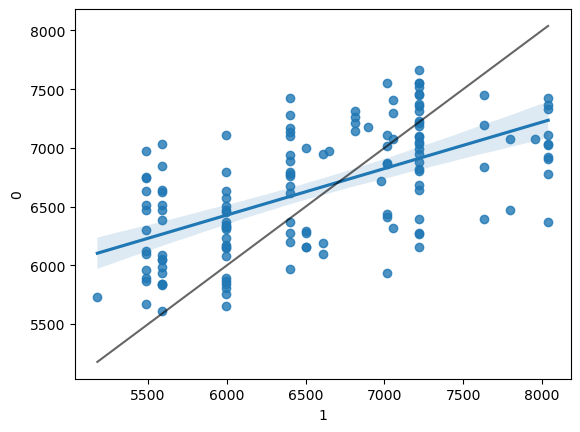

In [1107]:
preds = np.array(kfold_preds).mean(0)

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as msq, r2_score as r2
# comparison preds, real
preds_df = pd.DataFrame(pd.concat([pd.Series(preds), pd.Series(ytest.squeeze())], axis=1))\
.apply(lambda x:scaler_y.inverse_transform(x.values.reshape(-1, 1)).squeeze()).astype(int)\
.assign(error=lambda x:x[1] - x[0],
        mae=lambda x:mae(x[1], x[0])/len(yval),
        r2=lambda x:r2(x[1], x[0]))\

preds_df.pipe(lambda x:sns.regplot(data=x, x=x[1], y=x[0]))
plt.plot(np.arange(preds_df[1].min(), preds_df[1].max()), np.arange(preds_df[1].min(), preds_df[1].max()), c='k', ls='-', alpha=0.6)

preds_df.head()

## Retrain with full data

In [ ]:
models = KFoldTraining(x_const.values, x_ts, y, only_validation=True)

Setting custom data as val data


  0%|          | 0/500 [00:00<?, ?it/s]

30 time(s) has the accuracy not increased. Finishing training...
 best epoch: 137 best val_loss: 0.7034
Setting custom data as val data


  0%|          | 0/500 [00:00<?, ?it/s]

30 time(s) has the accuracy not increased. Finishing training...
 best epoch: 51 best val_loss: 0.8291
Setting custom data as val data


  0%|          | 0/500 [00:00<?, ?it/s]

30 time(s) has the accuracy not increased. Finishing training...
 best epoch: 71 best val_loss: 0.5994
Setting custom data as val data


  0%|          | 0/500 [00:00<?, ?it/s]

30 time(s) has the accuracy not increased. Finishing training...
 best epoch: 46 best val_loss: 0.918
Setting custom data as val data


  0%|          | 0/500 [00:00<?, ?it/s]

In [1161]:
# Average validation loss
np.array(models)[:, 1].mean()

0.7571514734200069

# Make predictions and submit

In [1162]:
kfold_preds = []
for m in np.array(models)[:, 0]:
    kfold_preds.append(scaler_y.inverse_transform(m(xsub_ts, xsub_const).detach().numpy()).squeeze())

TypeError: conv1d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, str, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mstr[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [32;1mstr[0m, [31;1mtuple[0m, [32;1mint[0m)


In [1150]:
sub_preds = np.array(kfold_preds).mean(0)
sub_preds

array([7360.8945, 6094.47  , 6405.4536, 7433.074 , 6346.484 , 7366.8374,
       6565.911 , 7115.5693, 7402.4243, 6976.05  , 6999.952 , 6437.9976,
       6838.9375, 6786.7188, 6943.763 , 7180.839 , 6263.413 , 6433.7764,
       6000.289 , 6726.9805, 7542.8057, 6107.429 , 7537.833 , 6371.3306,
       7301.6494, 7218.343 , 7331.121 , 6319.7993, 6808.5625, 6666.7256,
       6844.151 , 6082.7803, 7686.189 , 7095.1978, 6712.3525, 6979.1313,
       6225.093 , 6810.1553, 7015.142 , 6311.822 , 6714.4595, 6602.8813,
       7005.72  , 7416.6226, 5994.866 , 6474.013 , 6377.706 , 6968.784 ,
       6540.449 , 7324.8657, 6994.7124, 6942.927 , 6410.35  , 6795.8594,
       7259.367 , 7121.884 , 6789.2705, 7479.3936, 6511.9634, 5804.2046,
       6317.4287, 7136.3076, 6269.6978, 6612.568 , 6740.667 , 6642.496 ,
       6550.8335, 7047.8516, 7456.63  , 6231.27  , 6277.5723, 6883.2783,
       6597.421 , 6484.345 , 6915.557 , 6075.5327, 7410.7705, 6178.9136,
       6826.7437, 7091.1523, 6216.9194, 7215.2783, 

In [574]:
submission_df = pd.read_csv('Challenge_2_submission_template.csv')
submission_df['Predicted Rice Yield (kg/ha)'] = sub_preds
submission_df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,7035.584473
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,5985.058594
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,6405.698242
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,7367.402344
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,6404.052246


In [576]:
submission_df.to_csv('Version 1.csv', index=False)

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., mean, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

In [ ]:
## Get Sentinel-1-RTC Data
assests = ['vh','vv']
train_band_values=crop_yield_data.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]
vh_vv_data = pd.DataFrame(list(zip(vh,vv,vv_by_vh)),columns = ["vv_list","vh_list","vv/vh_list"])

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables. The <i><b>concat</b></i> function from pandas comes in handy here.

In [ ]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [ ]:
crop_data = combine_two_datasets(crop_yield_data,features_data)
crop_data.head()

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. Here we consider only the statistical features generated using the band values for training the model. Here we are not including latitude and longitude as predictor variables since they have no effect on the rice yield.</p>

In [ ]:
crop_data = crop_data[['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'correlation_vv', 'permutation_entropy_vv',
                          'min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh', 'permutation_entropy_vh',
                          'min_vv_by_vh',  'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh','Rice Yield (kg/ha)']]

In [ ]:
crop_data.head()

In [ ]:
crop_data.shape

### Train and Test Split 

<p align="justify">We will now split the data into 80% training data and 20% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [ ]:
X = crop_data.drop(columns=['Rice Yield (kg/ha)']).values
y = crop_data ['Rice Yield (kg/ha)'].values
# Choose any random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a Extra Tree Regressor  model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X.</p>

In [ ]:
regressor = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)
regressor.fit(X_train, y_train)

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the R2 Score. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a R2 Score for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. R2 Score is generated to gauge the robustness of the model. 

In [ ]:
insample_predictions = regressor.predict(X_train)

In [ ]:
print("Insample R2 Score: {0:.2f}".format(r2_score(y_train,insample_predictions)))

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit/underfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [ ]:
outsample_predictions = regressor.predict(X_test)

In [ ]:
print("Outsample R2 Score: {0:.2f}".format(r2_score(y_test,outsample_predictions)))

From the above, we can clearly see that the model is overfitting and is able to achieve an <strong>R2 score</strong> of <b>0.25</b>. This is not a very good model, so your goal is to improve this model and the R2 Score to its maximum.

## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make the yield predictions of rice crop for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/8515054086281302-63ca8f827b1fe300146c7e21-challenge_2_submission_template.csv"><b>"challenge_2_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [ ]:
test_file = pd.read_csv('challenge_2_submission_template.csv')
test_file.head()

In [ ]:
# Get Sentinel-1-RTC Data
assests = ['vh','vv']
submission_band_values=test_file.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
submission_vh = [x[0] for x in submission_band_values]
submission_vv = [x[1] for x in submission_band_values]
submission_vv_by_vh = [x[2] for x in submission_band_values]
submission_vh_vv_data = pd.DataFrame(list(zip(submission_vh,submission_vv,submission_vv_by_vh)),columns = ["vv_list","vh_list","vv/vh_list"])

In [ ]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(submission_vh_vv_data)
submission_features_data = pd.DataFrame(features ,columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'correlation_vv', 'permutation_entropy_vv',
                          'min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh', 'permutation_entropy_vh',
                          'min_vv_by_vh',  'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh'] )

In [ ]:
#Making predictions
final_predictions = regressor.predict(submission_features_data.values)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
test_file['Predicted Rice Yield (kg/ha)']=list(final_prediction_series)

In [ ]:
#Dumping the predictions into a csv file.
test_file.to_csv("challenge_2_submission_rice_crop_yield_prediction.csv",index = False)

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!